In [1]:
import os
import math
import numpy as np
import librosa
import hmmlearn.hmm as hmm
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
# Danh sách các nhãn
class_names = ['2.1', '2.2', '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '2.10']

# # Số trạng thái của mỗi mô hình HMM tương ứng với mỗi nhãn
states = [8, 6, 8, 9, 8, 8, 7, 8, 8, 8]

In [3]:
def get_mfcc(file_path):
    y, sr = librosa.load(file_path)
    hop_length = math.floor(sr * 0.010) # 10ms hop
    win_length = math.floor(sr * 0.025) # 25ms frame
    # Tính toán MFCC, delta và delta-delta
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13, n_fft=1024, hop_length=hop_length, win_length=win_length)
    mfcc = mfcc - np.mean(mfcc, axis=1).reshape((-1, 1)) # Chuẩn hóa MFCC
    delta1 = librosa.feature.delta(mfcc, order=1)
    delta2 = librosa.feature.delta(mfcc, order=2)
    X = np.concatenate([mfcc, delta1, delta2], axis=0) # Kết hợp các đặc trưng
    return X.T 

In [4]:
def prepare_data(base_directory):
    all_data = {}
    all_labels = {}
    for cname in class_names:
        directory = os.path.join(base_directory, cname)
        file_paths = [os.path.join(directory, i) for i in os.listdir(directory) if i.endswith('.wav')]
        
        data = []
        for file_path in file_paths:
            mfcc_features = get_mfcc(file_path)
            # Thêm dữ liệu MFCC vào danh sách
            data.append(mfcc_features)

        all_data[cname] = data
        all_labels[cname] = [class_names.index(cname) for i in range(len(file_paths))]
    return all_data, all_labels

train_data, train_labels = prepare_data('D:/PBL5/PBL5_CODE/DemoHMM/DATASET_phanloai/train')

In [5]:
# Huấn luyện và lưu mô hình
def train_and_save_models(all_data, all_labels):
    if not os.path.exists('D:/PBL5/PBL5_CODE/DemoHMM/model_train'):
        os.makedirs('D:/PBL5/PBL5_CODE/DemoHMM/model_train')

    # Tạo hai đồ thị trống
    fig1, ax1 = plt.subplots()
    ax1.set_title('Convergence of the model')
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Log-likelihood')

    fig2, ax2 = plt.subplots()
    ax2.set_title('Convergence of the model')
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Change in Log-likelihood')

    models = {}
    for idx, cname in enumerate(class_names):
        start_prob = np.full(states[idx], 0.0)
        start_prob[0] = 1.0
        trans_matrix = np.full((states[idx], states[idx]), 0.0)
        p = 0.5
        np.fill_diagonal(trans_matrix, p)
        np.fill_diagonal(trans_matrix[0:, 1:], 1 - p)
        trans_matrix[-1, -1] = 1.0

        print(f"Training {cname}")

        models[cname] = hmm.GMMHMM(
            n_components=states[idx],
            startprob_prior=start_prob,
            transmat_prior=trans_matrix,
            verbose=True,
            n_iter=300,
            params='stmc',
            init_params='mc',
            random_state=42,
            algorithm='viterbi',
            covariance_type='diag',
            tol=0.001,
            n_mix=3
        )

        models[cname].fit(X=np.vstack(all_data[cname]), lengths=[x.shape[0] for x in all_data[cname]])

        # Lấy log-likelihood sau mỗi lần lặp và chuyển đổi thành danh sách
        log_likelihoods = list(models[cname].monitor_.history)
        # Vẽ đường cho log-likelihood
        ax1.plot(log_likelihoods, label=cname)
        # Tính sự thay đổi của log-likelihood
        diffs = [j-i for i, j in zip(log_likelihoods[:-1], log_likelihoods[1:])]
        # Vẽ đường cho sự thay đổi của log-likelihood
        ax2.plot(diffs, label=cname)

    ax1.legend(ncol=2)
    ax2.legend(ncol=2)
    plt.show()

    # Lưu tất cả các mô hình vào một file model.pkl
    with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model2.pkl', 'wb') as file:
        pickle.dump(models, file)

    print("\nTraining and saving models done!!!")

Training 2.1


         1 -417156.19032295             +nan
         2 -390633.79257438  +26522.39774857
         3 -385182.89414035   +5450.89843403
         4 -382391.64944498   +2791.24469537
         5 -380183.30383211   +2208.34561287
         6 -378667.05492186   +1516.24891025
         7 -377977.13718271    +689.91773914
         8 -377472.40382424    +504.73335848
         9 -377007.49457383    +464.90925040
        10 -376712.38110028    +295.11347356
        11 -376456.96670481    +255.41439547
        12 -376345.93805721    +111.02864760
        13 -376258.10688971     +87.83116750
        14 -376151.91477499    +106.19211472
        15 -376037.37054432    +114.54423067
        16 -375951.78743125     +85.58311307
        17 -375903.07815071     +48.70928054
        18 -375856.54210894     +46.53604176
        19 -375805.51607760     +51.02603135
        20 -375775.29120774     +30.22486986
        21 -375764.31692188     +10.97428586
        22 -375758.59021542      +5.72670646
        23

Training 2.2


         1 -372634.15417133             +nan
         2 -348012.56815125  +24621.58602009
         3 -343287.10936564   +4725.45878560
         4 -341948.39246537   +1338.71690027
         5 -341304.55630867    +643.83615670
         6 -340891.84123536    +412.71507332
         7 -340550.01037510    +341.83086026
         8 -340173.91319120    +376.09718389
         9 -339816.53338895    +357.37980225
        10 -339441.79682110    +374.73656785
        11 -339269.93839651    +171.85842459
        12 -339189.23491625     +80.70348026
        13 -339099.96717382     +89.26774243
        14 -339052.00777550     +47.95939831
        15 -339029.01815005     +22.98962545
        16 -339011.43211558     +17.58603447
        17 -338992.88661597     +18.54549961
        18 -338976.10784553     +16.77877044
        19 -338962.69563834     +13.41220719
        20 -338954.86252698      +7.83311136
        21 -338951.73351729      +3.12900970
        22 -338949.73032670      +2.00319059
        23

Training 2.3


         1 -415950.34392842             +nan
         2 -394018.27508614  +21932.06884228
         3 -388651.89744414   +5366.37764200
         4 -386026.90967145   +2624.98777270
         5 -384516.24973256   +1510.65993888
         6 -383535.99929124    +980.25044133
         7 -382903.01472636    +632.98456488
         8 -382648.37111205    +254.64361431
         9 -382457.69871751    +190.67239454
        10 -382279.18066318    +178.51805433
        11 -382108.66290664    +170.51775654
        12 -381989.22245359    +119.44045304
        13 -381897.06163212     +92.16082148
        14 -381797.79707765     +99.26455447
        15 -381708.33198113     +89.46509652
        16 -381639.26107005     +69.07091107
        17 -381593.44306168     +45.81800838
        18 -381560.66059123     +32.78247044
        19 -381540.24524322     +20.41534801
        20 -381526.53285873     +13.71238450
        21 -381509.66337826     +16.86948047
        22 -381490.73152582     +18.93185243
        23

Training 2.4


         1 -392358.84377105             +nan
         2 -368321.36647420  +24037.47729685
         3 -362977.70328766   +5343.66318655
         4 -361116.39391638   +1861.30937128
         5 -360132.48848904    +983.90542734
         6 -359474.31715031    +658.17133872
         7 -359078.02349260    +396.29365771
         8 -358783.87337597    +294.15011664
         9 -358519.74786470    +264.12551127
        10 -358306.22356948    +213.52429522
        11 -358171.57379540    +134.64977408
        12 -358056.23088274    +115.34291266
        13 -357970.37840511     +85.85247764
        14 -357872.96401682     +97.41438828
        15 -357827.98042513     +44.98359169
        16 -357789.34291068     +38.63751445
        17 -357753.43852451     +35.90438617
        18 -357723.53385028     +29.90467424
        19 -357681.57028239     +41.96356789
        20 -357667.54643141     +14.02385098
        21 -357657.39760608     +10.14882533
        22 -357649.88822250      +7.50938358
        23

Training 2.5


         1 -344018.27543033             +nan
         2 -320800.39585349  +23217.87957684
         3 -316925.48299295   +3874.91286054
         4 -315272.31199980   +1653.17099315
         5 -314486.01896887    +786.29303093
         6 -313923.52734518    +562.49162369
         7 -313487.69701889    +435.83032629
         8 -313218.33464776    +269.36237113
         9 -313074.73718214    +143.59746563
        10 -312937.59841052    +137.13877162
        11 -312806.16927919    +131.42913133
        12 -312632.58830238    +173.58097681
        13 -312426.59728888    +205.99101350
        14 -312318.41256101    +108.18472788
        15 -312267.43660158     +50.97595942
        16 -312243.41238427     +24.02421731
        17 -312228.63330394     +14.77908033
        18 -312218.57264995     +10.06065399
        19 -312207.01931655     +11.55333340
        20 -312183.45329020     +23.56602635
        21 -312160.84596194     +22.60732826
        22 -312145.35976573     +15.48619621
        23

Training 2.6


         1 -346712.50543170             +nan
         2 -327935.03572353  +18777.46970817
         3 -324128.35897793   +3806.67674561
         4 -323219.21164021    +909.14733771
         5 -322874.73212287    +344.47951734
         6 -322696.13331324    +178.59880963
         7 -322614.95864459     +81.17466865
         8 -322563.86791377     +51.09073081
         9 -322490.91388219     +72.95403158
        10 -322393.70841008     +97.20547212
        11 -322331.22264475     +62.48576533
        12 -322298.64925929     +32.57338546
        13 -322259.52787869     +39.12138060
        14 -322245.96153311     +13.56634558
        15 -322223.35615978     +22.60537332
        16 -322193.88784155     +29.46831823
        17 -322161.20569484     +32.68214672
        18 -322147.48038323     +13.72531160
        19 -322130.99728914     +16.48309409
        20 -322116.20593942     +14.79134972
        21 -322104.17222731     +12.03371211
        22 -322081.92655167     +22.24567564
        23

Training 2.7


         1 -191699.19592858             +nan
         2 -171635.80101710  +20063.39491148
         3 -168405.52905315   +3230.27196395
         4 -167748.77032615    +656.75872700
         5 -167414.95531570    +333.81501045
         6 -167223.07077942    +191.88453628
         7 -167095.43195420    +127.63882522
         8 -167018.33921260     +77.09274160
         9 -166939.80453601     +78.53467660
        10 -166865.75543912     +74.04909689
        11 -166768.07976547     +97.67567365
        12 -166654.56398439    +113.51578109
        13 -166424.02115770    +230.54282669
        14 -166339.31169929     +84.70945841
        15 -166291.22944292     +48.08225637
        16 -166206.89125951     +84.33818342
        17 -166188.17796873     +18.71329078
        18 -166156.31015727     +31.86781146
        19 -166141.58982411     +14.72033316
        20 -166081.29808266     +60.29174145
        21 -166034.59592749     +46.70215517
        22 -165993.14946707     +41.44646043
        23

Training 2.8


         1 -338144.85196091             +nan
         2 -317742.08780582  +20402.76415509
         3 -312978.96225777   +4763.12554805
         4 -311429.16494869   +1549.79730909
         5 -310648.29351032    +780.87143837
         6 -310219.20617183    +429.08733848
         7 -309750.34389309    +468.86227875
         8 -309514.76243469    +235.58145840
         9 -309286.50582218    +228.25661251
        10 -309115.13569905    +171.37012313
        11 -309056.57083200     +58.56486704
        12 -308998.31976979     +58.25106221
        13 -308899.07062640     +99.24914339
        14 -308793.27108590    +105.79954050
        15 -308614.28616616    +178.98491973
        16 -308419.02360365    +195.26256252
        17 -308133.21756044    +285.80604321
        18 -307756.96325288    +376.25430755
        19 -307621.42994266    +135.53331023
        20 -307149.58038731    +471.84955534
        21 -306386.85833527    +762.72205205
        22 -305629.14778614    +757.71054913
        23

Training 2.9


         1 -334702.06120940             +nan
         2 -317481.43793992  +17220.62326948
         3 -313801.03408188   +3680.40385804
         4 -312470.01392944   +1331.02015243
         5 -311673.20102464    +796.81290481
         6 -311220.36638293    +452.83464171
         7 -310956.95345634    +263.41292659
         8 -310822.73655139    +134.21690495
         9 -310725.51384310     +97.22270829
        10 -310618.87964840    +106.63419470
        11 -310447.69293538    +171.18671302
        12 -310341.60314782    +106.08978756
        13 -310276.16516060     +65.43798723
        14 -310230.57254452     +45.59261607
        15 -310187.70021428     +42.87233025
        16 -310124.57352500     +63.12668927
        17 -310037.44420103     +87.12932398
        18 -309969.67703870     +67.76716233
        19 -309898.30657271     +71.37046599
        20 -309869.07269392     +29.23387879
        21 -309851.25766520     +17.81502872
        22 -309840.18228023     +11.07538496
        23

Training 2.10


         1 -403920.53105045             +nan
         2 -374109.29369784  +29811.23735261
         3 -368875.23176277   +5234.06193508
         4 -367006.03383266   +1869.19793010
         5 -365978.26667253   +1027.76716014
         6 -365380.97031689    +597.29635563
         7 -364945.60275764    +435.36755925
         8 -364661.39592382    +284.20683382
         9 -364454.18421481    +207.21170901
        10 -364340.00580879    +114.17840602
        11 -364262.10466965     +77.90113914
        12 -364218.12160175     +43.98306790
        13 -364180.00676316     +38.11483858
        14 -364142.19950867     +37.80725449
        15 -364102.61275904     +39.58674963
        16 -364067.85799640     +34.75476264
        17 -364033.99302430     +33.86497211
        18 -364004.33949880     +29.65352549
        19 -363973.48943052     +30.85006828
        20 -363892.05963451     +81.42979601
        21 -363756.59674132    +135.46289319
        22 -363648.35522766    +108.24151366
        23

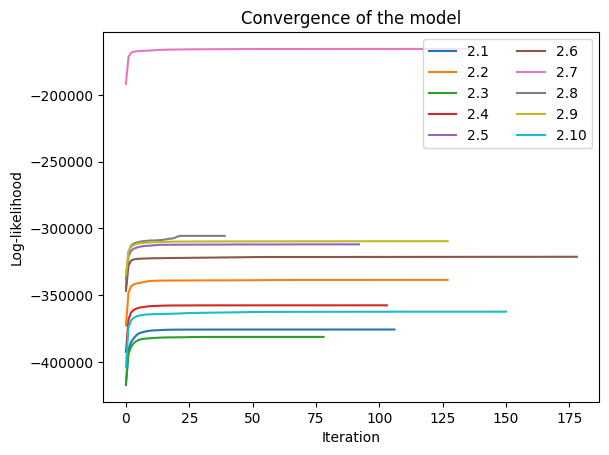

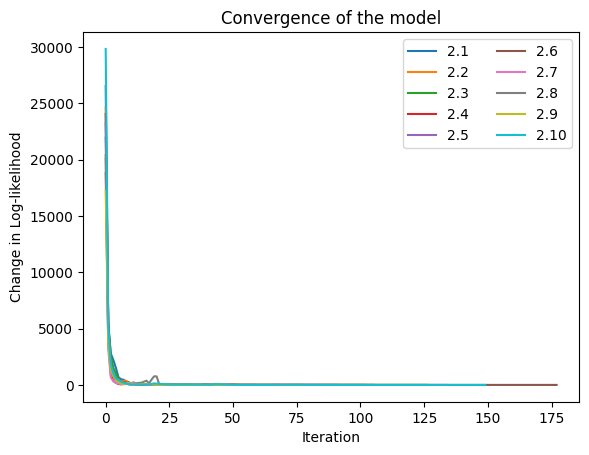


Training and saving models done!!!


In [6]:
# Load mô hình đã huấn luyện
def load_models():
    with open('D:/PBL5/PBL5_CODE/DemoHMM/model_train/model2.pkl', 'rb') as file:
        models = pickle.load(file)
    return models


# Huấn luyện và lưu mô hình
train_and_save_models(train_data, train_labels)
# Load mô hình đã huấn luyện
trained_models = load_models()

In [7]:
def classify_test_data(X_test, y_test, models):
    y_true = []
    y_predict = []
    for cname in class_names:
        for mfcc, target in zip(X_test[cname], y_test[cname]):
            scores = [models[cname].score(mfcc) for cname in class_names]
            pred = np.argmax(scores)
            y_predict.append(pred)
            y_true.append(target)

    # In báo cáo phân loại
    report = classification_report(y_true, y_predict, target_names=class_names, output_dict=True)
    print(report)

    # Chuyển đổi báo cáo thành DataFrame
    report_df = pd.DataFrame(report).transpose()
    # Xuất DataFrame vào tệp Excel
    report_df.to_excel("report2.xlsx")

    # In ma trận nhầm lẫn
    cm = confusion_matrix(y_true, y_predict)

    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    # Tính độ chính xác
    accuracy = np.sum(cm.diagonal()) / np.sum(cm)
    accuracy = np.round(accuracy, 4)
    print("Accuracy:", accuracy*100, "%")

{'2.1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.5': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.7': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, '2.10': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 10.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 100.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 100.0}}


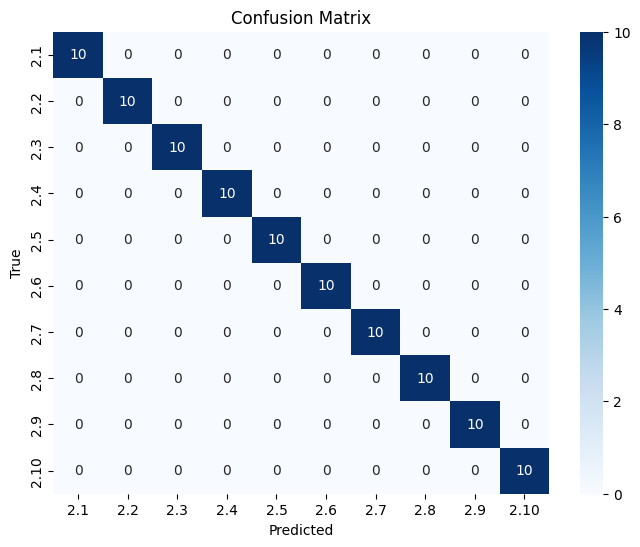

Accuracy: 100.0 %


In [8]:
test_data, test_labels = prepare_data('D:/PBL5/PBL5_CODE/DemoHMM/DATASET_phanloai/test')

classify_test_data(test_data, test_labels, trained_models)

In [9]:
# classify_test_data(train_data, train_labels, trained_models)